### Imports

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import torchtext
# import torchtext.data as ttd
import torchtext.legacy.data as ttd
from torchtext.vocab import GloVe
from sklearn.metrics import confusion_matrix
import itertools

%matplotlib inline

### Functions

In [2]:
def plot_confusion_matrix(cm, classes, normalize=False, title="Confusion matrix", cmap=plt.cm.Blues):
    if normalize:
        cm=cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")
    print(cm)
    
    plt.imshow(cm, interpolation="nearest",cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = ".2f" if normalize else "d"
    thresh = cm.max()/2.
    
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j],fmt),
                 horizontalalignment="center",
                 color="white" if cm[i,j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()


def index_to_token(itos,sent):
    out = []
    for i in sent:
        out.append(itos[int(i)])

    return out


class RNN(nn.Module):
    def __init__(self, n_vocab, embed_dim, n_hidden, n_rnnlayers, n_outputs, model_type, device):
        super(RNN,self).__init__()
        self.V = n_vocab
        self.D = embed_dim
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers
        self.model_type = model_type
        self.device = device
        
        self.embed = nn.Embedding(self.V, self.D)
        if self.model_type=="GRU":
            self.rnn = nn.GRU(
                input_size = self.D,
                hidden_size = self.M,
                num_layers = self.L,
                batch_first=True
            )
        elif self.model_type=="LSTM":
            self.rnn = nn.LSTM(
                input_size = self.D,
                hidden_size = self.M,
                num_layers = self.L,
                batch_first=True
            )
            
        self.fc = nn.Linear(self.M, self.K)
        
    def forward(self, X):
        h0 = torch.zeros(self.L, X.size(0), self.M).to(self.device)
        if self.model_type=="LSTM":
            c0 = torch.zeros(self.L, X.size(0), self.M).to(self.device)
            out = self.embed(X)
            out,_ = self.rnn(out, (h0,c0))
        elif self.model_type=="GRU":
            out = self.embed(X)
            out,_ = self.rnn(out, h0)
        
        out,_ = torch.max(out, 1)
        out = self.fc(out)
        return out



def create_model_and_train(train_iter,test_iter,V,D,M,L,K,n_epochs=100,model_type="LSTM"):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    
    if model_type=="GRU":
        model = RNN(n_vocab=V ,embed_dim=D, n_hidden=M, n_rnnlayers=L, n_outputs=K, model_type=model_type, device=device)
    elif model_type=="LSTM":
        model = RNN(n_vocab=V ,embed_dim=D, n_hidden=M, n_rnnlayers=L, n_outputs=K, model_type=model_type, device=device)


    model.to(device)
    
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters())
    
    train_losses = np.zeros(n_epochs)
    test_losses  = np.zeros(n_epochs)
    
    for it in range(n_epochs):
        t0 = datetime.now()
        train_loss = []
        for inputs,targets in train_iter:
            targets = targets.view(-1,1).float()
            optimizer.zero_grad()
        
            outputs = model(inputs)
            loss = criterion(outputs, targets)
        
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
        
        train_losses[it] = np.mean(train_loss)


        test_loss = []
        for inputs,targets in test_iter:
            targets = targets.view(-1,1).float()
        
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        
        test_losses[it] = np.mean(test_loss)

        dt = datetime.now() - t0

        if (it+1)%5==0:

            print(f"Epoch {it+1}/{n_epochs}, Train Loss: {train_losses[it]:.4f}, Test Loss: {test_losses[it]:.4f}")
        
    return model,train_losses, test_losses


def plot_metric(data, metric):
    plt.plot(data, label=metric)
    plt.legend()
    plt.show


def acc_compouter(model,device,data_loader):
    n_correct=0.
    n_total=0.
    y_test = []
    p_test = []
    for inputs,targets in data_loader:
        # inputs,targets = inputs.to(device), targets.to(device)
        targets = targets.view(-1,1).float()

        outputs = model(inputs)
        
        predictions = (outputs>0)

        y_test += list(targets.cpu().numpy())
        # p_test += predictions
        p_test += list(predictions.cpu().numpy())
        
        
        n_correct += (predictions == targets).sum().item()
        # .item() from torch to simple python data type
        n_total += targets.shape[0]
        
    acc = n_correct/n_total

    return acc, y_test, p_test

### Load data

In [5]:
df = pd.read_csv("./spam.csv", encoding="ISO-8859-1")

In [6]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [7]:
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)

In [8]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
df.columns = ["labels", "data"]

In [10]:
df["b_labels"] = df["labels"].map({"ham":0, "spam":1})

In [11]:
df2 = df[["data","b_labels"]]

In [12]:
df2.head()

,data,b_labels
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [13]:
df2.to_csv("spam2.csv", index=False)

In [14]:
TEXT = ttd.Field(
    sequential = True,
    batch_first = True,
    lower = True,
    # tokenize = 'spacy',
    pad_first = True
)
LABEL = ttd.Field(sequential = False, use_vocab = False, is_target = True)

In [15]:
dataset = ttd.TabularDataset(
    path = 'spam2.csv',
    format = 'csv',
    skip_header = True,
    fields = [('data',TEXT),('label',LABEL)]
)

In [16]:
# ex = dataset.examples[0]
# type(ex)
# ex.data
# ex.label

In [17]:
train_dataset , test_dataset = dataset.split() # default 0.7

In [18]:
TEXT.build_vocab(train_dataset)

In [19]:
vocab = TEXT.vocab

In [20]:
torchtext.vocab.Vocab

torchtext.vocab.Vocab

In [21]:
vocab.stoi

defaultdict(<bound method Vocab._default_unk_index of <torchtext.legacy.vocab.Vocab object at 0x7f47696f2fd0>>,
            {'<unk>': 0,
             '<pad>': 1,
             'to': 2,
             'i': 3,
             'you': 4,
             'a': 5,
             'the': 6,
             'u': 7,
             'and': 8,
             'in': 9,
             'is': 10,
             'my': 11,
             'for': 12,
             'your': 13,
             'of': 14,
             'me': 15,
             'have': 16,
             'call': 17,
             'on': 18,
             'are': 19,
             'it': 20,
             'that': 21,
             '2': 22,
             'so': 23,
             'but': 24,
             'at': 25,
             'or': 26,
             'not': 27,
             'can': 28,
             "i'm": 29,
             'ur': 30,
             'get': 31,
             'with': 32,
             'if': 33,
             'will': 34,
             'just': 35,
             'be': 36,
             'we': 37

In [22]:
vocab.itos

['<unk>',
 '<pad>',
 'to',
 'i',
 'you',
 'a',
 'the',
 'u',
 'and',
 'in',
 'is',
 'my',
 'for',
 'your',
 'of',
 'me',
 'have',
 'call',
 'on',
 'are',
 'it',
 'that',
 '2',
 'so',
 'but',
 'at',
 'or',
 'not',
 'can',
 "i'm",
 'ur',
 'get',
 'with',
 'if',
 'will',
 'just',
 'be',
 'we',
 'do',
 'this',
 '&lt;#&gt;',
 'from',
 'when',
 'go',
 'all',
 'now',
 '4',
 'no',
 'how',
 'got',
 'up',
 'what',
 'like',
 'know',
 'out',
 'was',
 'am',
 'then',
 'free',
 'come',
 'its',
 '.',
 'only',
 'good',
 'send',
 'time',
 'as',
 'text',
 'by',
 'he',
 '?',
 "i'll",
 'want',
 'going',
 'r',
 'txt',
 'still',
 'our',
 'about',
 'ok',
 'see',
 'love',
 'n',
 'one',
 'new',
 'she',
 'dont',
 'there',
 "don't",
 'need',
 'been',
 'has',
 '...',
 'mobile',
 'stop',
 'tell',
 'any',
 'they',
 'reply',
 'take',
 'think',
 'back',
 'please',
 '&',
 'claim',
 'home',
 'later',
 'ì_',
 'an',
 'day',
 'did',
 'hope',
 'now.',
 'who',
 'had',
 'me.',
 'hi',
 'some',
 'great',
 'happy',
 'her',
 "it'

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [24]:
train_iter, test_iter = ttd.Iterator.splits(
    (train_dataset,test_dataset), sort_key = lambda x: len(x.data),
    batch_sizes = (32, 256), device=device
)

In [25]:
for inputs, targets in train_iter:
    print("inputs", inputs, "shape", inputs.shape)
    # for input in inputs:
    #     print(index_to_token(vocab.itos,input))
    print("targets", inputs, "shape", targets.shape)
    break

inputs tensor([[   1,    1,    1,  ...,   50,   30, 5276],
        [   1,    1,    1,  ...,   51,    2,  490],
        [   1,    1,    1,  ...,    3,  203, 1007],
        ...,
        [   1,    1,    1,  ...,   59,  105, 1475],
        [   1,    1,    1,  ..., 2379,   12, 3006],
        [   1,    1,    1,  ...,    7,  242, 1007]], device='cuda:0') shape torch.Size([32, 32])
targets tensor([[   1,    1,    1,  ...,   50,   30, 5276],
        [   1,    1,    1,  ...,   51,    2,  490],
        [   1,    1,    1,  ...,    3,  203, 1007],
        ...,
        [   1,    1,    1,  ...,   59,  105, 1475],
        [   1,    1,    1,  ..., 2379,   12, 3006],
        [   1,    1,    1,  ...,    7,  242, 1007]], device='cuda:0') shape torch.Size([32])


In [26]:
for inputs, targets in test_iter:
    print("inputs", inputs, "shape", inputs.shape)
    # for input in inputs:
    #     print(index_to_token(vocab.itos,input))
    print("targets", inputs, "shape", targets.shape)
    break

inputs tensor([[2809,   19,    0, 1693, 9292, 4231],
        [   3,   64,    6, 8900,    0,  280],
        [ 127,   59, 1208,  175,    0,  762],
        ...,
        [   1,    1,    1,    1,    1,    0],
        [   1,    1,    1,    1,    1,   79],
        [   1,    1,    1,    1,    1,  334]], device='cuda:0') shape torch.Size([256, 6])
targets tensor([[2809,   19,    0, 1693, 9292, 4231],
        [   3,   64,    6, 8900,    0,  280],
        [ 127,   59, 1208,  175,    0,  762],
        ...,
        [   1,    1,    1,    1,    1,    0],
        [   1,    1,    1,    1,    1,   79],
        [   1,    1,    1,    1,    1,  334]], device='cuda:0') shape torch.Size([256])


### Create and train model

In [27]:
model,train_losses, test_losses = create_model_and_train(train_iter,test_iter,V=len(vocab),D=20,M=15,L=1,K=1,n_epochs=50,model_type="LSTM")

cuda:0
Epoch 5/50, Train Loss: 0.1263, Test Loss: 0.1978
Epoch 10/50, Train Loss: 0.0410, Test Loss: 0.1636
Epoch 15/50, Train Loss: 0.0226, Test Loss: 0.1685
Epoch 20/50, Train Loss: 0.0146, Test Loss: 0.1721
Epoch 25/50, Train Loss: 0.0100, Test Loss: 0.1897
Epoch 30/50, Train Loss: 0.0064, Test Loss: 0.2030
Epoch 35/50, Train Loss: 0.0051, Test Loss: 0.2166
Epoch 40/50, Train Loss: 0.0047, Test Loss: 0.2185
Epoch 45/50, Train Loss: 0.0031, Test Loss: 0.2084
Epoch 50/50, Train Loss: 0.0022, Test Loss: 0.2052


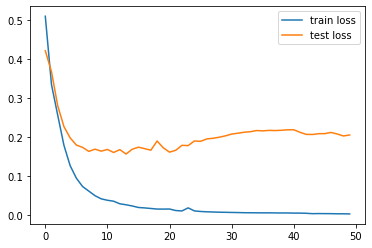

In [28]:
plot_metric(train_losses, "train loss")
plot_metric(test_losses, "test loss")

In [29]:
acc_train, y_train, p_train = acc_compouter(model,device,train_iter)
print(acc_train)

0.9994871794871795


In [30]:
acc_test, y_test, p_test = acc_compouter(model,device,test_iter)
print(acc_test)

0.9647129186602871


In [31]:
df[df["labels"] == "spam"].size / df.size

0.13406317300789664

Confusion matrix, without normalization
[[1442    8]
 [  51  171]]


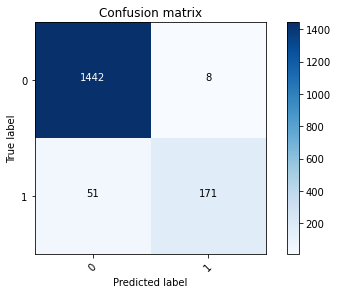

In [32]:
cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, [0,1])

Confusion matrix, without normalization
[[3375    0]
 [   2  523]]


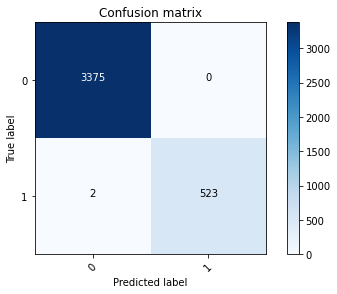

In [33]:
cm = confusion_matrix(y_train, p_train)
plot_confusion_matrix(cm, [0,1])

In [34]:
small_sample = df[df.labels=="spam"].sample(3)
small_sample

,labels,data,b_labels
2310,spam,You have won a Nokia 7250i. This is what you g...,1
400,spam,FREE RINGTONE text FIRST to 87131 for a poly o...,1
2619,spam,<Forwarded from 21870000>Hi - this is your Mai...,1


In [35]:
with open("sample_test.csv", "w") as f:
    f.write("data\n")
    for i, row in small_sample.iterrows():
        f.write(row["data"] + "\n")

In [36]:
sample_dataset = ttd.TabularDataset(
    path = 'sample_test.csv',
    format = 'csv',
    skip_header = True,
    fields = [('data',TEXT)]
)

In [37]:
sample_iter = ttd.Iterator(
    sample_dataset, sort_key = lambda x: len(x.data),
    batch_size = 32, device=device
)

In [38]:
for inputs in sample_iter:
    print("inputs:", inputs)

    outputs = model(inputs.data)

    print(outputs)

inputs: 
[torchtext.legacy.data.batch.Batch of size 3]
	[.data]:[torch.cuda.LongTensor of size 3x28 (GPU 0)]
tensor([[7.2086],
        [7.7625],
        [7.7654]], device='cuda:0', grad_fn=<AddmmBackward>)


In [42]:
single_sentence = "Our dating service has been asked 2 contact U by someone shy! CALL 090503303 NOW and all will be revealed."

In [43]:
TEXT.preprocess(single_sentence)

['our',
 'dating',
 'service',
 'has',
 'been',
 'asked',
 '2',
 'contact',
 'u',
 'by',
 'someone',
 'shy!',
 'call',
 '090503303',
 'now',
 'and',
 'all',
 'will',
 'be',
 'revealed.']

In [45]:
TEXT.numericalize([TEXT.preprocess(single_sentence)])

tensor([[  77,  622,  228,   91,   90,  322,   22,  148,    7,   68,  221, 9497,
           17,    0,   45,    8,   44,   34,   36, 1436]])

In [46]:
toks = TEXT.preprocess(single_sentence)
sent_idx = TEXT.numericalize([toks])

model(sent_idx.to(device))

tensor([[6.0398]], device='cuda:0', grad_fn=<AddmmBackward>)